In [1]:
%matplotlib widget

In [2]:
import torch
import cv2
import torchvision.models as models
from PIL import Image
import torch.nn as nn
import numpy as np
from torchvision import transforms
transform = transforms.Compose([            #[1]
# transforms.Resize((224, 224)),              #[2] 224 x 224
# transforms.CenterCrop(224),                #[3] 
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

class FeatureExtractor(nn.Module):
    def __init__(self, submodule, extracted_layers):
        super(FeatureExtractor, self).__init__()
        self.submodule = submodule
        self.extracted_layers = extracted_layers
 
    # 自己修改forward函数
    def forward(self, x):
        outputs = []
        #print('forward')
        for name, module in self.submodule._modules.items():
            #print(x.shape)
            #print(name)
            #print(module)
            if name == "fc":
                x = x.view(x.size(0), -1)
            x = module(x)
            if name in self.extracted_layers:
                outputs.append(x)
        return outputs

extract_list = ["conv1", "layer1", "avgpool", "fc"]

In [3]:
from  matplotlib import pyplot as plt
import utils
from tqdm import tqdm
from scipy import spatial

In [4]:
img = Image.open('bottle_data\\train\\PLUS100\\0P81031-144611.jpg')
plt.imshow(img)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#加载参数
weights = torch.load('pretrained_model\\resnet101-5d3b4d8f.pth')
#print(weights) 
#用参数加载模型
net = models.resnet101(pretrained=False)
net.load_state_dict(weights)

<All keys matched successfully>

In [4]:
path = "bottle_data\\train"

In [5]:
train_data, train_labels = utils.load_data(path)

In [130]:
len(train_data)

195

In [42]:
img = Image.open(train_data[0])
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)
result = extract_net(batch_t)
feat_2048 = result[2].data.numpy()
feat_2048 = np.squeeze(feat_2048)

In [43]:
feat_2048

array([0.48146126, 0.43384483, 0.18113558, ..., 0.18898724, 0.17340761,
       0.33753178], dtype=float32)

# 提取特征

In [55]:
def extract_feature(net, path):
    img = Image.open(path)
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    result = net(batch_t)
    feat_2048 = result[2].data.numpy()
    feat_2048 = np.squeeze(feat_2048)
    return feat_2048

In [36]:
extract_net = FeatureExtractor(net, extract_list)
features = np.empty(2048)
for file_path in tqdm(train_data):
    img = Image.open(file_path)
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    result = extract_net(batch_t)
    feat_2048 = result[2].data.numpy()
    feat_2048 = np.squeeze(feat_2048)
    features = np.vstack((features,feat_2048))

100%|██████████| 195/195 [05:45<00:00,  1.77s/it]


In [50]:
arr = np.delete(features, 0, 0)

In [52]:
arr.shape

(195, 2048)

# 测试

In [123]:
test_path = "bottle_data\\test"

In [124]:
test_data, test_labels = utils.load_data(test_path)

In [126]:
len(test_data)

2123

In [125]:
count = 0
for i, file_path in enumerate(test_data):
    feat_2048 = extract_feature(extract_net, file_path)
    scores = cos_matrix_multiplication(feat_2048, arr)
    y_pred = train_labels[np.argmin(scores)]         #预测种类
    y = test_labels[i]               #实际
    #print(i," y_pred:",y_pred," y:", y,"count:",count)
    if y == y_pred:
        count += 1
print("ACC:", count/len(test_data))

KeyboardInterrupt: 

In [128]:
count = 0 
for i in tqdm(range(2123)):
    feat_2048 = extract_feature(extract_net, test_data[i])
    scores = cos_matrix_multiplication(feat_2048, arr)
    y_pred = train_labels[np.argmin(scores)]         #预测种类
    y = test_labels[i]               #实际
    if y == y_pred:
        count += 1
    #else:
        #print(i," y_pred:",y_pred," y:", y,"count:",count)
print("ACC:", count/len(test_data))

100%|██████████| 2123/2123 [52:08<00:00,  1.47s/it] 

ACC: 0.916156382477626


In [129]:
count

1945

In [56]:
test_feature = extract_feature(extract_net, "cola.jpg")

In [57]:
test_feature

(2048,)

In [109]:
def cos_matrix_multiplication(vector,matrix_1): #余弦相似度
    v = vector.reshape(1, -1)
    scores1 = spatial.distance.cdist(matrix_1, v, 'cosine')
    return(scores1)

In [98]:
scores = cos_matrix_multiplication(test_feature, arr)

(1, 2048)
[[0.23040552 0.14949879 0.31434727 ... 0.13502939 0.1032001  0.12969452]]
(195, 2048)
[0.48146126 0.43384483 0.18113558 ... 0.18898724 0.17340761 0.33753178]
(195, 1)


In [99]:
np.argmin(scores)

64

In [131]:
train_data

['bottle_data\\train\\PLUS100\\0IMG_20181029_143606.jpg',
 'bottle_data\\train\\PLUS100\\0IMG_20181029_144514.jpg',
 'bottle_data\\train\\PLUS100\\0P81031-144611.jpg',
 'bottle_data\\train\\PLUS100\\0P81031-144924.jpg',
 'bottle_data\\train\\PLUS100\\3P81031-144921.jpg',
 'bottle_data\\train\\东方树叶乌龙茶\\0IMG_4310.JPG',
 'bottle_data\\train\\东方树叶乌龙茶\\0P81031-142900.jpg',
 'bottle_data\\train\\东方树叶乌龙茶\\0P81031-142945.jpg',
 'bottle_data\\train\\东方树叶乌龙茶\\0P81031-143001.jpg',
 'bottle_data\\train\\东方树叶乌龙茶\\0P81031-143143.jpg',
 'bottle_data\\train\\东鹏特饮\\0IMG_4057.JPG',
 'bottle_data\\train\\东鹏特饮\\0IMG_4077.JPG',
 'bottle_data\\train\\东鹏特饮\\0P81029-143702.jpg',
 'bottle_data\\train\\东鹏特饮\\0P81029-143858.jpg',
 'bottle_data\\train\\东鹏特饮\\0P81029-143903.jpg',
 'bottle_data\\train\\优益C\\0IMG_4750.JPG',
 'bottle_data\\train\\优益C\\0P81029-152206.jpg',
 'bottle_data\\train\\优益C\\0P81029-152231.jpg',
 'bottle_data\\train\\优益C\\0P81029-152235.jpg',
 'bottle_data\\train\\优益C\\1IMG_4761.JPG',
 'bottle

In [136]:
import os
def load_dict(path):
    label_dict = {}
    folder_lst = os.listdir(path)
    for i, folder in enumerate(folder_lst):
        label_dict[folder] = i
    return label_dict

In [137]:
labels_dict = load_dict(path)

In [138]:
labels_dict

{'PLUS100': 0,
 '东方树叶乌龙茶': 1,
 '东鹏特饮': 2,
 '优益C': 3,
 '佳得乐': 4,
 '农夫山泉': 5,
 '农夫山泉小瓶': 6,
 '农夫果园': 7,
 '冰锐-粉': 8,
 '冰锐-紫': 9,
 '加多宝瓶装': 10,
 '可口可乐mini': 11,
 '可口可乐瓶装': 12,
 '可口可乐零度': 13,
 '娃哈哈AD钙奶': 14,
 '小明同学-青': 15,
 '小明同学-黄': 16,
 '尖叫': 17,
 '康师傅冰红茶': 18,
 '怡宝': 19,
 '恒大冰泉': 20,
 '昆仑山': 21,
 '海之言': 22,
 '爱夸': 23,
 '王老吉瓶装': 24,
 '百事可乐瓶装': 25,
 '百岁山': 26,
 '统一冰红茶': 27,
 '统一阿萨姆奶茶': 28,
 '美年达': 29,
 '脉动': 30,
 '茶n': 31,
 '雀巢咖啡': 32,
 '雅哈冰咖啡': 33,
 '雪碧-纤维': 34,
 '雪碧mini': 35,
 '雪碧瓶装': 36,
 '青岛啤酒大听装': 37,
 '青岛啤酒小听装': 38}

# OTHER

In [53]:
np.save("saved_features\\features_2048.npy", arr)

In [15]:
f = np.load("saved_features\\features_2048.npy")

In [7]:
img = Image.open('bottle_data\\train\\PLUS100\\0P81031-144611.jpg')
img_t = transform(img)

In [26]:
img_np = img_t.data.numpy()

In [27]:
img_np.transpose(1,2,0).shape

(1327, 371, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


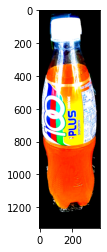

In [28]:
plt.imshow(img_np.transpose(1,2,0))

In [8]:
batch_t = torch.unsqueeze(img_t, 0)
print(batch_t.shape)
#预测
net.eval()
out = net(batch_t)
print(out.shape)
_, index = torch.max(out, 1)

#标签
with open('labels.txt') as f:
    classes = [line.strip() for line in f.readlines()]
#
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(classes[index[0]], percentage[index[0]].item())
#
extract_result = FeatureExtractor(net, extract_list)

result = extract_result(batch_t)

torch.Size([1, 3, 1327, 371])
torch.Size([1, 1000])
737: 'pop bottle, soda bottle', 10.845508575439453
forward


In [18]:
feat_2048 = result[2].data.numpy() #avgpool
feat_2048 = np.squeeze(feat_2048)

In [19]:
feat_2048.shape

(2048,)

# 特征可视化

In [42]:
feat = result[1].data.numpy()
feat = np.squeeze(feat)

In [43]:
feat.shape

(256, 332, 93)

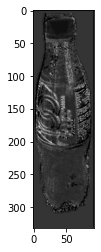

In [44]:
plt.imshow(feat[6,:,:], cmap='gray')

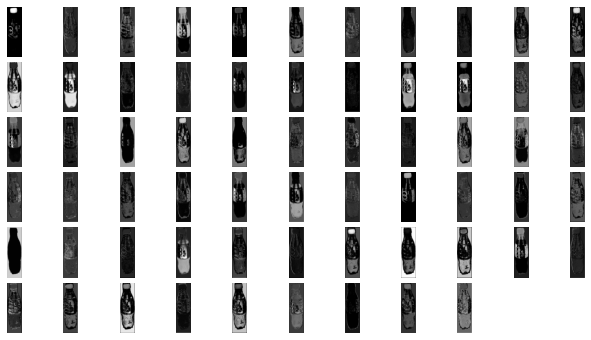

In [45]:
plt.figure(figsize=(11,6))
for ii in range(64):
    plt.subplot(6, 11, ii+1)
    plt.imshow(feat[ii,:,:], cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()